In [38]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import torchvision.datasets as dsets
import math
import torchvision.models as models
from PIL import Image
from deepfool import deepfool
import os,sys
from FGSM import fgsm,fgsm_graybox
from train_mnist_model import Net
from tqdm import tqdm
from torch.distributions.categorical import Categorical
import metrics
homedir = '/home/serge/Documents/Classes/Adversarial_ML/Examining-Robustness-of-BNNs-to-Adversarial-Examples/'

MODULE_PATH = ['{}BNN_Implementations/PyTorch-BayesianCNN-master'.format(homedir),
          '{}BNN_Implementations/PyTorch-BayesianCNN-master/models/BayesianModels'.format(homedir)]

for m in MODULE_PATH:
    sys.path.append(m)
from BayesianLeNet import BBBLeNet

In [39]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [40]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])
test_loader = test_loader = torch.utils.data.DataLoader(
        dsets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=False)

In [41]:
model = Net()
model.load_state_dict(torch.load('mnist_cnn.pt'))
model.eval()
device = torch.device('cuda:0')
model.to(device)
loss = nn.CrossEntropyLoss()
loss = nn.CrossEntropyLoss()

# Example attack on a non-Bayes CNN (MNIST)

In [42]:
def attack_fgsm(model,loss,eps,device,loader):
    original_preds_soft = []
    attack_preds_soft = []
    for batch_idx, (images, labels) in enumerate(loader):
        attack_images = fgsm(model=model,loss=loss,device=device,images=images,labels=labels,eps=eps)
        original_preds_soft.append(model(images.to(device)).detach())
        attack_preds_soft.append(model(attack_images).detach())
        
    original_preds_soft = torch.cat(original_preds_soft, dim=0)
    attack_preds_soft = torch.cat(attack_preds_soft,dim=0)
    original_preds = torch.argmax(original_preds_soft,axis=1)
    attack_preds = torch.argmax(attack_preds_soft,axis=1)
    
    success_rate = torch.mean((original_preds!=attack_preds).type(torch.DoubleTensor)).cpu().detach().numpy()
    entropy = np.mean(Categorical(probs = attack_preds_soft).entropy().cpu().detach().numpy())
    return success_rate,entropy

epsilons = np.linspace(0,2,101)
success_rates = []
entropies = []
for eps in tqdm(epsilons):
    success_rate,entropy = attack_fgsm(model,loss,eps,device,test_loader)
    success_rates.append(success_rate)
    entropies.append(entropy)


  2%|▏         | 2/101 [00:03<02:51,  1.74s/it]

KeyboardInterrupt: 

Text(0,0.5,'Prediction entropy')

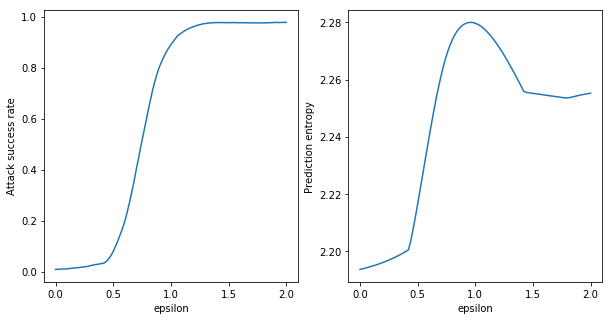

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,success_rates)
plt.xlabel('epsilon')
plt.ylabel('Attack success rate')
plt.subplot(1,2,2)
plt.plot(epsilons,entropies)
plt.xlabel('epsilon')
plt.ylabel('Average predictive entropy')

# Example attack on BayesNet

In [46]:
model = BBBLeNet(outputs=10,inputs=1)
ckpt_path = 'BNN_Implementations/PyTorch-BayesianCNN-master/checkpoints/MNIST/bayesian'
ckpt_name = 'model_lenet.pt'
model.load_state_dict(torch.load(os.path.join(homedir,ckpt_path,ckpt_name)))
model.eval()
device = torch.device('cuda:0')
model.to(device)
loss = metrics.ELBO(len(test_loader.dataset)).to(device)
# loss = F.nll_loss()

AttributeError: 'module' object has no attribute 'nll_loss'

In [44]:
epsilons = np.linspace(0,2,101)
success_rates = []
entropies = []
for eps in tqdm(epsilons):
    success_rate,entropy = attack_fgsm(model,loss,eps,device,test_loader)
    success_rates.append(success_rate)
    entropies.append(entropy)


  0%|          | 0/101 [00:00<?, ?it/s]

TypeError: forward() takes at least 4 arguments (3 given)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,success_rates)
plt.xlabel('epsilon')
plt.ylabel('Attack success rate')
plt.subplot(1,2,2)
plt.plot(epsilons,entropies)
plt.xlabel('epsilon')
plt.ylabel('Average predictive entropy')